In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My Drive/HAL

/content/gdrive/My Drive/HAL


In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
import json
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

In [0]:
def read_statement_response_pairs(file_name='data/statement_response_pair.txt'):
    with open(file_name) as f:
        statement_resp_pairs = [l.strip().split(' +++$+++ ') for l in f]
    return statement_resp_pairs

In [0]:
statement_resp_pairs = read_statement_response_pairs()[:200]

In [0]:
### Add <BOS> Beginning Of Statement and <EOS> End Of Statement
statement_resp_pairs = [ ["<BOS> " + pair[0] + " <EOS>", "<BOS> " + pair[1] + " <EOS>"] for pair in statement_resp_pairs]

In [0]:
MAX_WORDS=823 ## found with MAX_WORDS=80000; len(set([t for pair in tok_statement_resp_pairs for p in pair for t in p]))
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts([uterance for pair in statement_resp_pairs for uterance in pair])

In [0]:
tok_statement_resp_pairs = [tokenizer.texts_to_sequences(pair) for pair in tqdm(statement_resp_pairs)]

100%|██████████| 200/200 [00:00<00:00, 17314.31it/s]


In [0]:
len(set([t for pair in tok_statement_resp_pairs for p in pair for t in p]))

822

In [0]:
tokenizer.word_index

{"'": 74,
 "'bout": 477,
 "'em": 680,
 "'guy": 454,
 "'me": 529,
 "'re": 799,
 "'til": 572,
 '90210': 534,
 '9th': 331,
 'a': 6,
 'about': 77,
 'act': 622,
 'actually': 88,
 'ad': 311,
 'advice': 621,
 'after': 336,
 'afterwards': 632,
 'again': 254,
 'agent': 586,
 'alcatraz': 427,
 'all': 85,
 'allowed': 325,
 'already': 756,
 'altar': 764,
 'always': 73,
 'an': 80,
 'and': 9,
 'andrew': 471,
 'angry': 787,
 'any': 135,
 'anymore': 633,
 'anything': 189,
 'apeshit': 624,
 'are': 51,
 "aren't": 207,
 'around': 795,
 'art': 523,
 'as': 161,
 'ask': 180,
 'asked': 628,
 'asking': 480,
 'ass': 750,
 'assail': 753,
 'at': 53,
 'attachment': 510,
 'attempting': 365,
 'away': 102,
 'awfully': 593,
 'awhile': 770,
 'babble': 300,
 'babe': 333,
 'back': 170,
 'band': 755,
 'barrett': 472,
 'battle': 735,
 'be': 50,
 'beautiful': 642,
 'because': 71,
 'become': 542,
 'becoming': 603,
 'been': 171,
 'before': 168,
 'being': 588,
 'believe': 521,
 'believer': 328,
 'belly': 234,
 'bend': 375,
 '

46


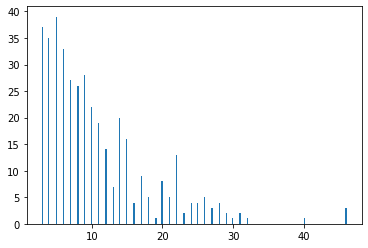

In [0]:
print(max([len(p) for pair in tok_statement_resp_pairs for p in pair]))
plt.hist([len(p) for pair in tok_statement_resp_pairs for p in pair], bins=250)
plt.show()

In [0]:
MAX_SEQ_LEN=30 # Observe the above graph to decide the max sequence length

In [0]:
# one hot embedding
tok_statement_resp_pairs = [[[[0]*p + [1]+ [0]*(MAX_WORDS-p) for p in pair[0]], 
                             [[0]*p + [1]+ [0]*(MAX_WORDS-p) for p in pair[1]]] \
                            for pair in tqdm(tok_statement_resp_pairs)]
tok_pad_st_resp_pairs = \
    [[pair[0]+[[0]*(MAX_WORDS+1)]*(MAX_SEQ_LEN-len(pair[0])) if len(pair[0]) < MAX_SEQ_LEN else pair[0][:MAX_SEQ_LEN],
      pair[1]+[[0]*(MAX_WORDS+1)]*(MAX_SEQ_LEN-len(pair[1])) if len(pair[1]) < MAX_SEQ_LEN else pair[1][:MAX_SEQ_LEN]] \
     for pair in tqdm(tok_statement_resp_pairs)]

100%|██████████| 200/200 [00:00<00:00, 23659.21it/s]


In [0]:
x_data, y_data = zip(*tok_pad_st_resp_pairs)
#y_data_shift = np.roll(y_data, -1, axis=0)
y_data_shift = np.array(y_data)

In [0]:
input_layer = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,MAX_WORDS+1))
masked_layer = tf.keras.layers.Masking(mask_value=0)
masked_input_layer = masked_layer(input_layer) # masking layer
LSTM_encoder_layer_1 = tf.keras.layers.LSTM(256, return_state=True)
LSTM_encoder_output, LSTM_encoder_state_h, LSTM_encoder_state_c  = LSTM_encoder_layer_1(masked_input_layer)

decode_input_layer = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,MAX_WORDS+1))
masked_decode_input_layer = masked_layer(decode_input_layer)
LSTM_decode_layer_1 = tf.keras.layers.LSTM(256, return_state=True, return_sequences=True)
LSTM_decoder_outputs, _, _ = LSTM_decode_layer_1(masked_decode_input_layer, initial_state=[LSTM_encoder_state_h, LSTM_encoder_state_c])
dense_out = tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')(LSTM_decoder_outputs)

model = tf.keras.Model([input_layer, decode_input_layer], dense_out)
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=[])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.fit([x_data, y_data], y_data_shift, epochs=5, batch_size=20)

Train on 200 samples
Epoch 1/5
200/200 [==============================] - 8s 40ms/sample - loss: 2.4315
Epoch 2/5
200/200 [==============================] - 6s 31ms/sample - loss: 2.4086
Epoch 3/5
200/200 [==============================] - 6s 31ms/sample - loss: 2.2017
Epoch 4/5
200/200 [==============================] - 6s 31ms/sample - loss: 1.9617
Epoch 5/5
200/200 [==============================] - 6s 31ms/sample - loss: 1.8741


In [0]:
y_pred = np.zeros_like(x_data, dtype=np.float32)

for i in tqdm(range(MAX_SEQ_LEN)):
    _p = model.predict([x_data, y_pred])
    for j in range(len(y_pred)):
        np.copyto(y_pred[j][i], _p[j][i])
#    for _p_dest, _p_src in zip(y_pred, _p):
#        _p_dest[i] = _p_src[i]

100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


In [0]:
tokenizer.sequences_to_texts([[np.argmax(tok) for tok in seq ] for seq in y_pred])

['bos bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bos bos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos',
 'bos bo

In [0]:
tokenizer.sequences_to_texts([[np.argmax(tok) for tok in seq]for seq in x_data])

['bos can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again eos',
 "bos well i thought we'd start with pronunciation if that's okay with you eos",
 'bos not the hacking and gagging and spitting part please eos',
 "bos you're asking me out that's so cute what's your name again eos",
 "bos no no it's my fault we didn't have a proper introduction eos",
 'bos cameron eos',
 "bos the thing is cameron i'm at the mercy of a particularly hideous breed of loser my sister i can't date until she does eos",
 'bos why eos',
 'bos unsolved mystery she used to be really popular when she started high school then it was just like she got sick of it or something eos',
 'bos gosh if only we could find kat a boyfriend eos',
 "bos c'esc ma tete this is my head eos",
 "bos right see you're ready for the quiz eos",
 "bos i don't want to know how to say that though i want to know useful things like where the good stores are how much doe